# 1- Getting data and preprocessing
The dataset we'll be using is CNN/DailyMail. Since it has about 300k samples, we will be only taking a portion of the samples.
5k -> training set
1k -> testing set
500 -> validation set
<!--
This section will also contain the preprocessing. Since we want to generate emotional summaries, the training data must be emotional and not objective. That is why, after getting the 6500 samples, we will pass it through chat gpt to add emotion to the summaries. -->

Installing the dependencies

In [1]:
!pip install datasets
!pip install transformers==4.28.0
!pip install evaluate
!pip install rouge_score
!pip install evaluate bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

Imports for the project

In [2]:
import json
import os
import random
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from evaluate import load
import evaluate
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import (
    PegasusTokenizer,
    PegasusForConditionalGeneration,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    Trainer,
    T5Tokenizer,
    T5ForConditionalGeneration,
    EarlyStoppingCallback,
)


# 1.1- Getting the CNN/DailyMail data

In [ ]:
# Load CNN/DailyMail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train")

random.seed(42)
sample_size = 5000
shuffled = dataset.shuffle(seed=42)
samples = shuffled.select(range(sample_size))

output_file = "cnn_dailymail_5000_samples.json"
with open(output_file, "w") as f:
    for example in samples:
        f.write(json.dumps(example) + "\n")

In [ ]:
# Get non duplicated set for test and validation to be prepocessed
train_file = "cnn_dailymail_5000_samples.json"
with open(train_file, "r") as file:
    train_data = [json.loads(line) for line in file]

train_ids = {entry["id"] for entry in train_data}

test_size = 1500
test_data = [entry for entry in dataset["validation"] if entry["id"] not in train_ids][:test_size]


test_file = "cnn_dailymail_test_samples.json"
with open(test_file, "w") as file:
    for entry in test_data:
        file.write(json.dumps(entry) + "\n")

# 1.2- Reformat data to be passed through transformers

Now we have the data and it has to be passed through chatgp.

Originally we wanted to feed the data, emotion prefixed to the model because there were no emotional summaries dataset available. Having it emotion prefixed wouldve meant that the model would have learned by inference. However, we discovered that we can ask chatgpt to rewrite the objective cnn/dailyMail summaries into emotional versions. Now we do not need the data to be emotion prefixed and the model can directly learn from the summaries provided.

Here we can go ahead and load the two json files with the modified data. 5000 samples for training, 500 samples for validation and 1000 samples for testing.

Although you can get the data from the first section, that is objective data. The emotional data will be added to the repo linked to this project. The 3 json files have to be added to the files to this notebook and then we can load them.

Reformat data to be used with PEGASUS

We need to use the PEGASUS tokenizer here because PEGASUS needs a specific way to perform tokenizing.


In [3]:
# define tokenizer and pass data
dataset = load_dataset("json", data_files={"train": "cnn_dailymail_5000_train.json", "validation": "cnn_dailymail_500_validation.json","test": "cnn_dailymail_1000_testing.json"})

tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail")

def tokenize_function(example):
    model_input = tokenizer(
        example["article"], max_length=512, truncation=True, padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["highlights"], max_length=64, truncation=True, padding="max_length"
        )
    model_input["labels"] = labels["input_ids"]
    return model_input

tokenized_dataset = dataset.map(tokenize_function, batched=True)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
print("Train size:", len(tokenized_dataset["train"]))
print("Validation size:", len(tokenized_dataset["validation"]))
print("Test size:", len(tokenized_dataset["test"]))
print("Total samples:", len(tokenized_dataset))

Train size: 5000
Validation size: 500
Test size: 1000
Total samples: 3


Only run 1 model at a time -- not both PEGASUS and T5 at the same time. We will need to restart the session.

Reformat data for T5

In [14]:
# Load dataset
datasetT5 = load_dataset("json", data_files={
    "train": "cnn_dailymail_5000_train.json",
    "validation": "cnn_dailymail_500_validation.json",
    "test": "cnn_dailymail_1000_testing.json"
})

tokenizer = T5Tokenizer.from_pretrained("t5-base")

def tokenize_t5(example):
    input_texts = ["summarize: " + doc for doc in example["article"]]
    target_texts = example["highlights"]

    model_inputs = tokenizer(
        input_texts,
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_texts,
            max_length=64,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset_T5 = datasetT5.map(tokenize_t5, batched=True)



spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
print("Train size:", len(tokenized_dataset_T5["train"]))
print("Validation size:", len(tokenized_dataset_T5["validation"]))
print("Test size:", len(tokenized_dataset_T5["test"]))
print("Total samples:", len(tokenized_dataset_T5))

Train size: 5000
Validation size: 500
Test size: 1000
Total samples: 3


# 2- Fine-tuning a partially frozen PEGASUS model

Now that we have teh data ready, we can load a pretrained PEGASUS model. We will first try to partially freeze it and fine tune it with our data.


# 2.1- Pegasus-xsum

This section includes the first iteration of the PEGASUS model. It was run wiht the T4 GPU and took around 1.5 hours to train 3 epochs. Did not evaluate model because it was not a viable option. Section 2.2 goes more in depth into the fine tuning and evaluation of another PEGASUS model with a A100 GPU. Section 3 also goes in depth in an alternate route taken to try with a lighter model, the T5.

This model google/pegasus-cnn_dailymail was tested and was too heavy-- uses resources too quickly

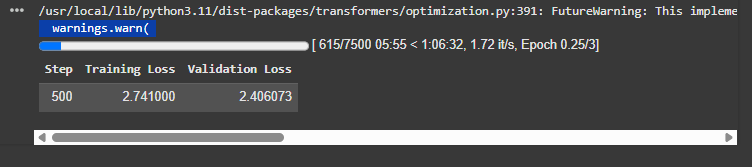

In [ ]:
os.environ["WANDB_DISABLED"] = "true"  # Disable W&B completely
# disabled because it is a service that requires an API key to provide metrics. We can set up our own.

In [17]:
model_name = "google/pegasus-xsum"
# model chosen because it is lighter than PEGASUS cnn daily mail
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [18]:
# Partially freezing model to make it train faster
for param in model.model.encoder.parameters():
    param.requires_grad = False
for param in model.model.shared.parameters():
    param.requires_grad = False


In [20]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="./pegasus-emotion-small",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    disable_tqdm=False,
)


# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
# Train model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,3.182600,2.657376
1000,2.429300,2.467634
1500,2.343900,2.390127
2000,2.264000,2.344913
2500,2.191000,2.316259
3000,2.152500,2.296318
3500,2.135300,2.278381
4000,2.142300,2.264802
4500,2.123400,2.254485
5000,2.063600,2.247688


TrainOutput(global_step=7500, training_loss=2.2215352783203124, metrics={'train_runtime': 5969.0422, 'train_samples_per_second': 2.513, 'train_steps_per_second': 1.256, 'total_flos': 2.167098310656e+16, 'train_loss': 2.2215352783203124, 'epoch': 3.0})

Took about 1.5 hours ro train 2 epochs on a smaller PEGASUS. It is not a viable option. It consumes too many resources and so we can explore another model and/or try stronger GPUs.

# 2.2 Pegasus CNN daily mail with colab pro

After having had issues wiht using the basic T4 GPU, we had to invest in resources and so we are not limited to use the smallest PEGASUS model.

Here, we will be running and fine-tuning the CNN_dailymail version of PEGASUS with our emotional summaries.

In [5]:
# Here again disabling WANDB because we do not want to use the service for metrics.
os.environ["WANDB_DISABLED"] = "true"


In [6]:
# Load model PEGASUS model
model_name = "google/pegasus-cnn_dailymail"
model = PegasusForConditionalGeneration.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [7]:
# Freeze the encoder (fine tune on decoder layers)
for param in model.model.encoder.parameters():
    param.requires_grad = False

In [8]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./pegasus_emotional_summariesV3",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    fp16=True,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    lr_scheduler_type="linear",

)

#add early stopping after first version
callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

# Training loop
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    callbacks=callbacks,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:645: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Various versions were ran of this model:

V1 Hyperparams:
*   learning rate = 5e-5
*   Number of epochs = 3
*   Batch sizes = 4
*   Weight decay = 0.01

RESULTS:

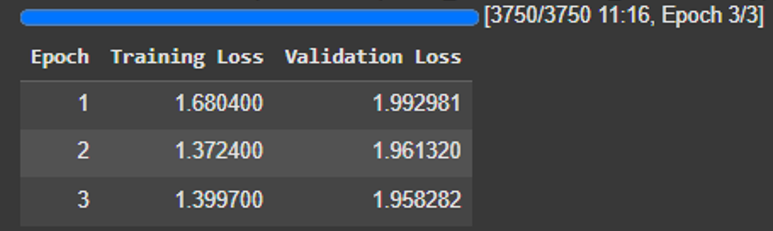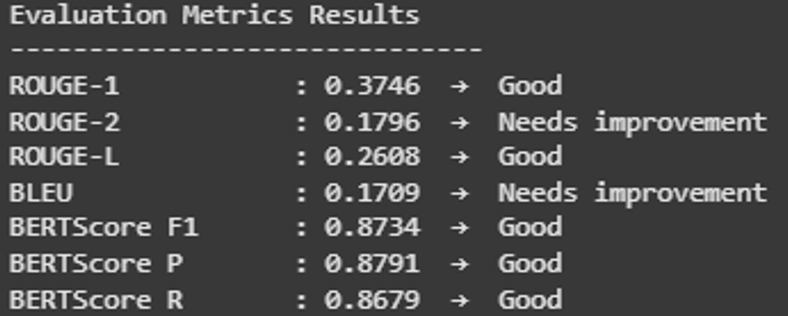

---

(batch sizes of more than 4 made the training crash because it was out of memory)

V2 Hyperparams
*   learning rate = 1e-5
*   Number of epochs = 5
*   Batch sizes = 4
*   Weight decay = 0.01

Changes made to learning rate and epochs because training on V1 showed a plateaing loss instead of decreasing. Also Added early stopping to help.

RESULTS:

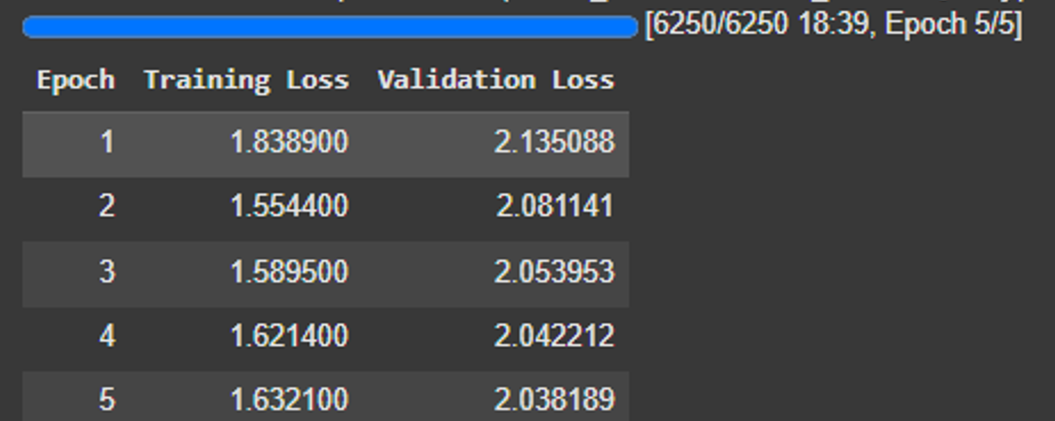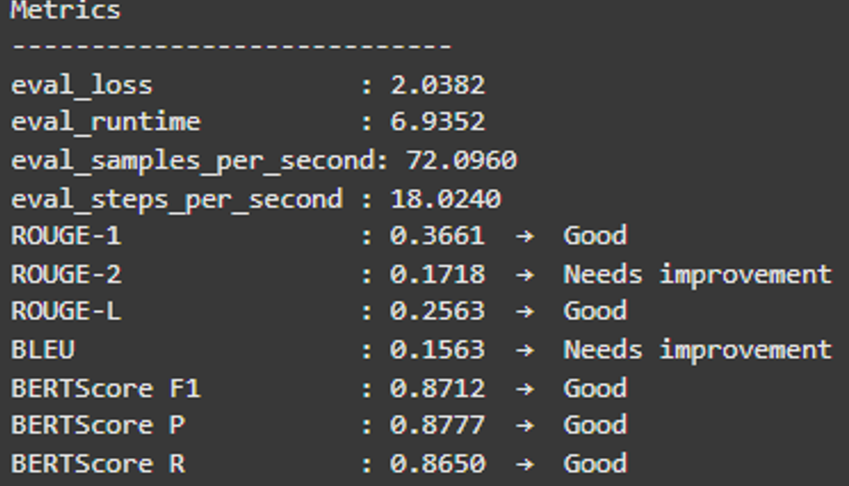

---

V3 Hyperparams
*   learning rate = 1e-5
*   Number of epochs = 5
*   Batch sizes = 4
*   Weight decay = 0.01

Added linear scheduler to help with plateauing results

RESULTS: Best results and the ones on the notebook right now.

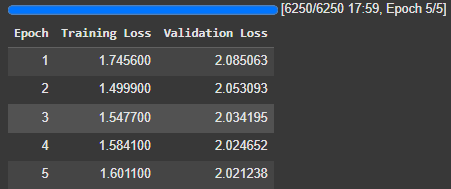

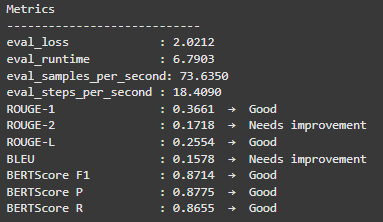

---

V4 Hyperparams
*   learning rate = 5e-6
*   Number of epochs = 5
*   Batch sizes = 4
*   Weight decay = 0.001

Changes to first learning rate and smaller weight decay.

RESULTS:

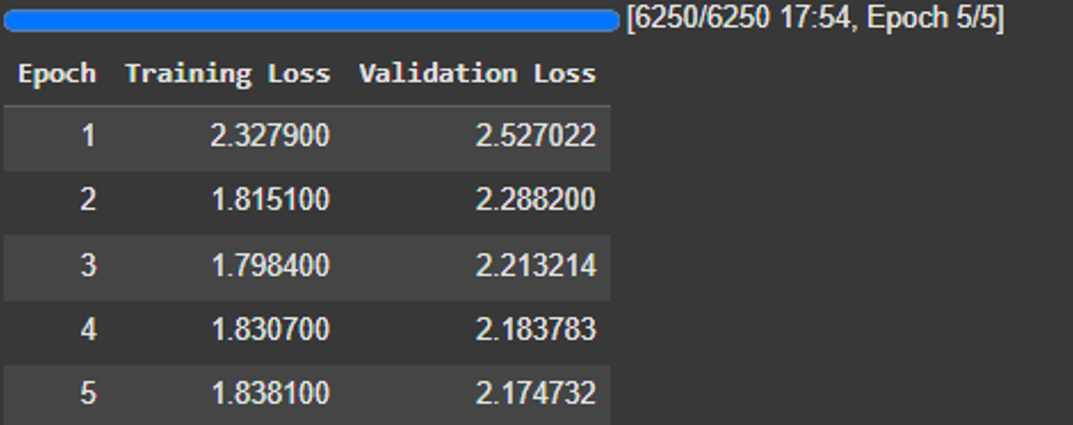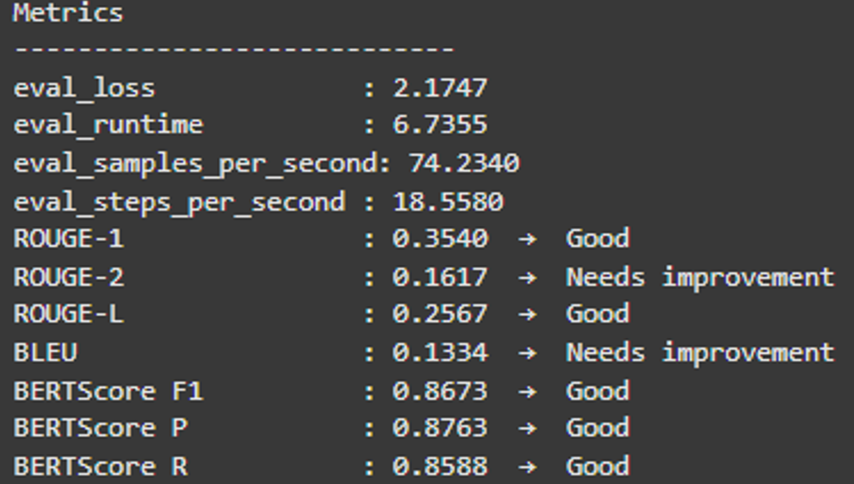


In [9]:
# Train the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


Epoch,Training Loss,Validation Loss
1,1.985500,2.251940
2,1.624000,2.129320
3,1.639600,2.085544
4,1.667000,2.069044
5,1.677000,2.063085


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', a

TrainOutput(global_step=6250, training_loss=1.8263139135742188, metrics={'train_runtime': 1095.3295, 'train_samples_per_second': 22.824, 'train_steps_per_second': 5.706, 'total_flos': 3.61183051776e+16, 'train_loss': 1.8263139135742188, 'epoch': 5.0})

In [17]:
trainer.save_model("./pegasus_emotional_summariesV3")
tokenizer.save_pretrained("./pegasus_emotional_summariesV3")

('./pegasus_emotional_summariesV3/tokenizer_config.json',
 './pegasus_emotional_summariesV3/special_tokens_map.json',
 './pegasus_emotional_summariesV3/spiece.model',
 './pegasus_emotional_summariesV3/added_tokens.json')

Model is now trained, we can evaluate on the metrics scores.

In [10]:
# Define metrics to evaluate the models
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

def evaluate_model(model, tokenizer, dataset, batch_size=4):
    all_preds = []
    all_labels = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset)))).to_dict()

        inputs = tokenizer(
            batch["article"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=64,
                num_beams=4,
                early_stopping=True
            )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_preds.extend([pred.strip() for pred in decoded_preds])
        all_labels.extend([label.strip() for label in batch["highlights"]])


    # Compute metrics
    metrics = {}
    metrics.update(rouge.compute(predictions=all_preds, references=all_labels))
    metrics["bleu"] = bleu.compute(predictions=all_preds, references=[[ref] for ref in all_labels])["bleu"]
    bert = bertscore.compute(predictions=all_preds, references=all_labels, lang="en")
    metrics["bertscore_precision"] = np.mean(bert["precision"])
    metrics["bertscore_recall"] = np.mean(bert["recall"])
    metrics["bertscore_f1"] = np.mean(bert["f1"])

    return metrics

In [11]:
def display_metrics(metrics):
    print("Metrics ")
    print("----------------------------" )

    def assess(metric_name, value, threshold=0.25):
        status = "Good" if value >= threshold else "Needs improvement"
        print(f"{metric_name:<22}: {value:.4f}  →  {status}")

    # Built-in metrics (loss, runtime, etc.)
    trainer_keys = ["eval_loss", "eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
    for key in trainer_keys:
        if key in metrics:
            print(f"{key:<22}: {metrics[key]:.4f}")

    # ROUGE scores
    assess("ROUGE-1", metrics.get("rouge1", 0))
    assess("ROUGE-2", metrics.get("rouge2", 0))
    assess("ROUGE-L", metrics.get("rougeL", 0))

    # BLEU score
    assess("BLEU", metrics.get("bleu", 0), threshold=0.2)

    # BERTScore components
    assess("BERTScore F1", metrics.get("bertscore_f1", 0), threshold=0.85)
    assess("BERTScore P", metrics.get("bertscore_precision", 0), threshold=0.85)
    assess("BERTScore R", metrics.get("bertscore_recall", 0), threshold=0.85)


Load and evaluate the best model to use

In [12]:
trainer_metrics = trainer.evaluate()
test_metrics = evaluate_model(model, tokenizer, tokenized_dataset['test'])
all_metrics = {**trainer_metrics, **test_metrics}

display_metrics(all_metrics)

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


100%|██████████| 250/250 [06:05<00:00,  1.46s/it]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Metrics 
----------------------------
eval_loss             : 2.0631
eval_runtime          : 6.8265
eval_samples_per_second: 73.2440
eval_steps_per_second : 18.3110
ROUGE-1               : 0.3669  →  Good
ROUGE-2               : 0.1723  →  Needs improvement
ROUGE-L               : 0.2583  →  Good
BLEU                  : 0.1543  →  Needs improvement
BERTScore F1          : 0.8706  →  Good
BERTScore P           : 0.8772  →  Good
BERTScore R           : 0.8642  →  Good


In [13]:
for i in range(5):
    sample = tokenized_dataset["test"][i]
    input_ids = tokenizer(
        sample["article"],
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    ).input_ids.to(model.device)

    generated_ids = model.generate(
        input_ids,
        max_length=64,
        num_beams=5,
        early_stopping=True
    )

    generated_summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    actual_summary = sample["highlights"]

    print(f"\n Summary {i+1}")
    print("Generated Summary:\n", generated_summary)
    print("Actual Summary:\n", actual_summary)



 Summary 1
Generated Summary:
 It's heartbreaking to hear that a woman donates one of her kidneys to a stranger. Many are shaken by the revelation that genetic data is used to match donors with recipients. It's heartbreaking to hear that the chain of surgeries is to be wrapped up Friday.
Actual Summary:
 With heavy hearts, we learn that zully broussard decided to give a kidney to a stranger . With heavy hearts, we learn that a new computer program helped her donation spur transplants for six kidney patients .

 Summary 2
Generated Summary:
 It's heartbreaking to hear that mls begins 20th season with 20 teams. Many are shaken by the revelation that number of teams has doubled from 10 to 20. Many are shaken by the revelation that attendances are higher than ever before.
Actual Summary:
 The world reacts with disbelief: the 20th mls season begins this weekend . With heavy hearts, we learn that league has changed dramatically since its inception in 1996 . It's heartbreaking to hear that s

# 3- Fine-tuning with a T5 model


In [16]:
# here again disabling W&B as well as setting a memory limit because this model had a lot of mempry issues while running
os.environ["WANDB_DISABLED"] = "true"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [19]:
# Load the tokenizer and model
model_name_T5 = "t5-base"
model_T5 = T5ForConditionalGeneration.from_pretrained(model_name_T5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [21]:
# Set up the Trainer
training_args = TrainingArguments(
    output_dir='./t51',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=3,
    save_steps=500,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    fp16=True,
    lr_scheduler_type="linear",
)

# define trainer
trainer = Trainer(
    model=model_T5,
    args=training_args,
    train_dataset=tokenized_dataset_T5["train"],
    eval_dataset=tokenized_dataset_T5["validation"],
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Various versions were ran of this model:

V1 Hyperparams:
*   learning rate = 2e-5
*   Number of epochs = 3
*   Batch sizes = 4
*   Weight decay = 0.01

RESULTS:

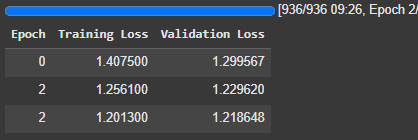
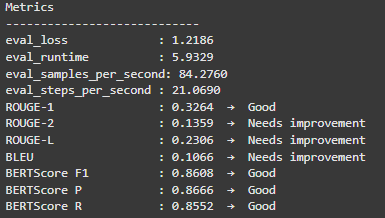

(batch sizes of more than 4 made the training crash because it was out of memory)

---

V2 Hyperparams
*   learning rate = 1e-5
*   Number of epochs = 5
*   Batch sizes = 4
*   Weight decay = 0.01

RESULTS:

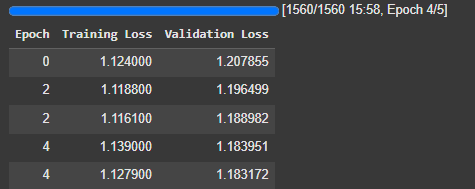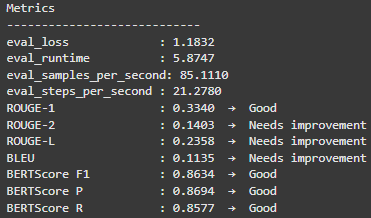

Small improvemnts all throughout.

---

V3 Hyperparams
*   learning rate = 1e-5
*   Number of epochs = 5
*   Batch sizes = 4
*   Weight decay = 0.01

Add a scheduler, linear

RESULTS:

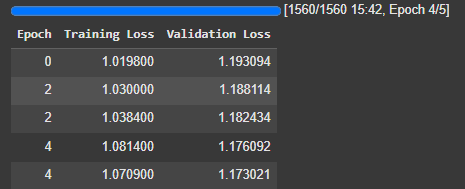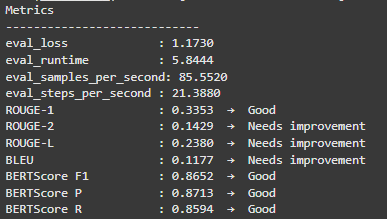

Still seeing some improvemnt in terms of loss and metric scores but it is very slow. PEGASUS seems to react better to the emotional summary fine tuning.

In [22]:
# Train model
trainer.train()

# Save the trained model
trainer.save_model("./t5_1")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,1.674700,1.497158
2,1.377900,1.302625
2,1.282100,1.257053
4,1.267000,1.240471
4,1.243200,1.235875


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', a

Rerun evaluate_model() and display_metrics() if it wasn't done before

In [29]:
# Define metrics to evaluate the models
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

def evaluate_model(model, tokenizer, dataset, batch_size=4):
    all_preds = []
    all_labels = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset)))).to_dict()

        inputs = tokenizer(
            batch["article"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=64,
                num_beams=4,
                early_stopping=True
            )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_preds.extend([pred.strip() for pred in decoded_preds])
        all_labels.extend([label.strip() for label in batch["highlights"]])


    # Compute metrics
    metrics = {}
    metrics.update(rouge.compute(predictions=all_preds, references=all_labels))
    metrics["bleu"] = bleu.compute(predictions=all_preds, references=[[ref] for ref in all_labels])["bleu"]
    bert = bertscore.compute(predictions=all_preds, references=all_labels, lang="en")
    metrics["bertscore_precision"] = np.mean(bert["precision"])
    metrics["bertscore_recall"] = np.mean(bert["recall"])
    metrics["bertscore_f1"] = np.mean(bert["f1"])

    return metrics

In [ ]:
def display_metrics(metrics):
    print("Metrics ")
    print("----------------------------" )

    def assess(metric_name, value, threshold=0.25):
        status = "Good" if value >= threshold else "Needs improvement"
        print(f"{metric_name:<22}: {value:.4f}  →  {status}")

    # Show Trainer built-in metrics (loss, runtime, etc.)
    trainer_keys = ["eval_loss", "eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
    for key in trainer_keys:
        if key in metrics:
            print(f"{key:<22}: {metrics[key]:.4f}")

    # ROUGE scores
    assess("ROUGE-1", metrics.get("rouge1", 0))
    assess("ROUGE-2", metrics.get("rouge2", 0))
    assess("ROUGE-L", metrics.get("rougeL", 0))

    # BLEU score
    assess("BLEU", metrics.get("bleu", 0), threshold=0.2)

    # BERT Score
    assess("BERT Score F1", metrics.get("bertscore_f1", 0), threshold=0.85)
    assess("BERT Score P", metrics.get("bertscore_precision", 0), threshold=0.85)
    assess("BERT Score R", metrics.get("bertscore_recall", 0), threshold=0.85)

In [23]:
trainer_metrics = trainer.evaluate()
test_metrics = evaluate_model(model_T5, tokenizer, tokenized_dataset_T5['test'])
all_metrics = {**trainer_metrics, **test_metrics}

display_metrics(all_metrics)

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2664: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)


100%|██████████| 250/250 [06:28<00:00,  1.55s/it]


Metrics 
----------------------------
eval_loss             : 1.2359
eval_runtime          : 5.8960
eval_samples_per_second: 84.8030
eval_steps_per_second : 21.2010
ROUGE-1               : 0.3254  →  Good
ROUGE-2               : 0.1366  →  Needs improvement
ROUGE-L               : 0.2307  →  Needs improvement
BLEU                  : 0.1061  →  Needs improvement
BERTScore F1          : 0.8600  →  Good
BERTScore P           : 0.8658  →  Good
BERTScore R           : 0.8543  →  Good


In [25]:
for i in range(5):
    sample = tokenized_dataset_T5["test"][i]
    input_ids = tokenizer(
        sample["article"],
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    ).input_ids.to(model_T5.device)

    generated_ids = model_T5.generate(
        input_ids,
        max_length=64,
        num_beams=5,
        early_stopping=True
    )

    generated_summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    actual_summary = sample["highlights"]

    print(f"\nSummary {i+1}")
    print("Generated Summary:\n", generated_summary)
    print("Actual Summary:\n", actual_summary)


Summary 1
Generated Summary:
 The world reacts with disbelief: Zully Broussard gave one of her kidneys to a stranger. The world reacts with disbelief: data processing of genetic profiles from donor-recipient pairs. It's heartbreaking to hear that the chain of surgeries
Actual Summary:
 With heavy hearts, we learn that zully broussard decided to give a kidney to a stranger . With heavy hearts, we learn that a new computer program helped her donation spur transplants for six kidney patients .

Summary 2
Generated Summary:
 It's heartbreaking to hear that in a shocking turn of events, it was the first ever Major League Soccer match. It's heartbreaking to hear that the world reacts with disbelief: the world reacts with disbelief. It's heartbreaking to
Actual Summary:
 The world reacts with disbelief: the 20th mls season begins this weekend . With heavy hearts, we learn that league has changed dramatically since its inception in 1996 . It's heartbreaking to hear that some question whether 